<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep2-eda-modeling-submission?scriptVersionId=161572810" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

* Version 1 (01/31/2024)

    * EDA and Baseline modeling 1.0
    
    
* Version 2 (02/01/2024)
    
    * Baseline modeling 1.0 updated.
    
    
* Version 3 (02/03/2024)
    
    * ExtraTrees added to baseline modeling 1.0.
    
    
* Version 4 (02/03/2024)
    
    * Fixing bug.



  

# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data File

In [2]:
train = pd.read_csv('../input/playground-series-s4e2/train.csv')
test = pd.read_csv('../input/playground-series-s4e2/test.csv')
submission = pd.read_csv('../input/playground-series-s4e2/sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (20758, 18)
The dimension of the test dataset is: (13840, 17)


In [3]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


First, we check for missing values in the `train` an `test` datasets.

In [5]:
train.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [6]:
test.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

From the above, we see there are no missing values neither in the `train` nor `test` datasets. Next, we proceed to explore the data.

# Data Exploration

We start by visualizing `NObeyesdad`, which is the target feature. 

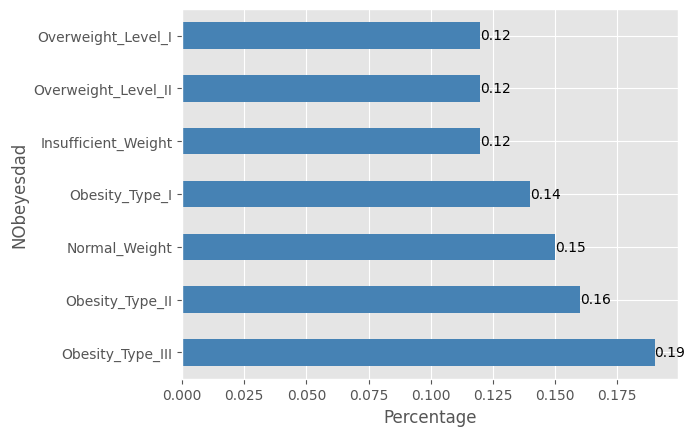

In [7]:
ax = round(train['NObeyesdad'].value_counts(normalize = True), 2).plot(kind = 'barh', color = 'steelblue')
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.margins(y = 0.1)
plt.xlabel('Percentage');

From the above chart, these are a couple of observations:

* `NObeyesdad` has seven labels.
* `NObeyesdad` is a lite imbalanced; however, it is not that extreme.

Next, we explore potential relationships between the numerical features and `NObeyesdad`.

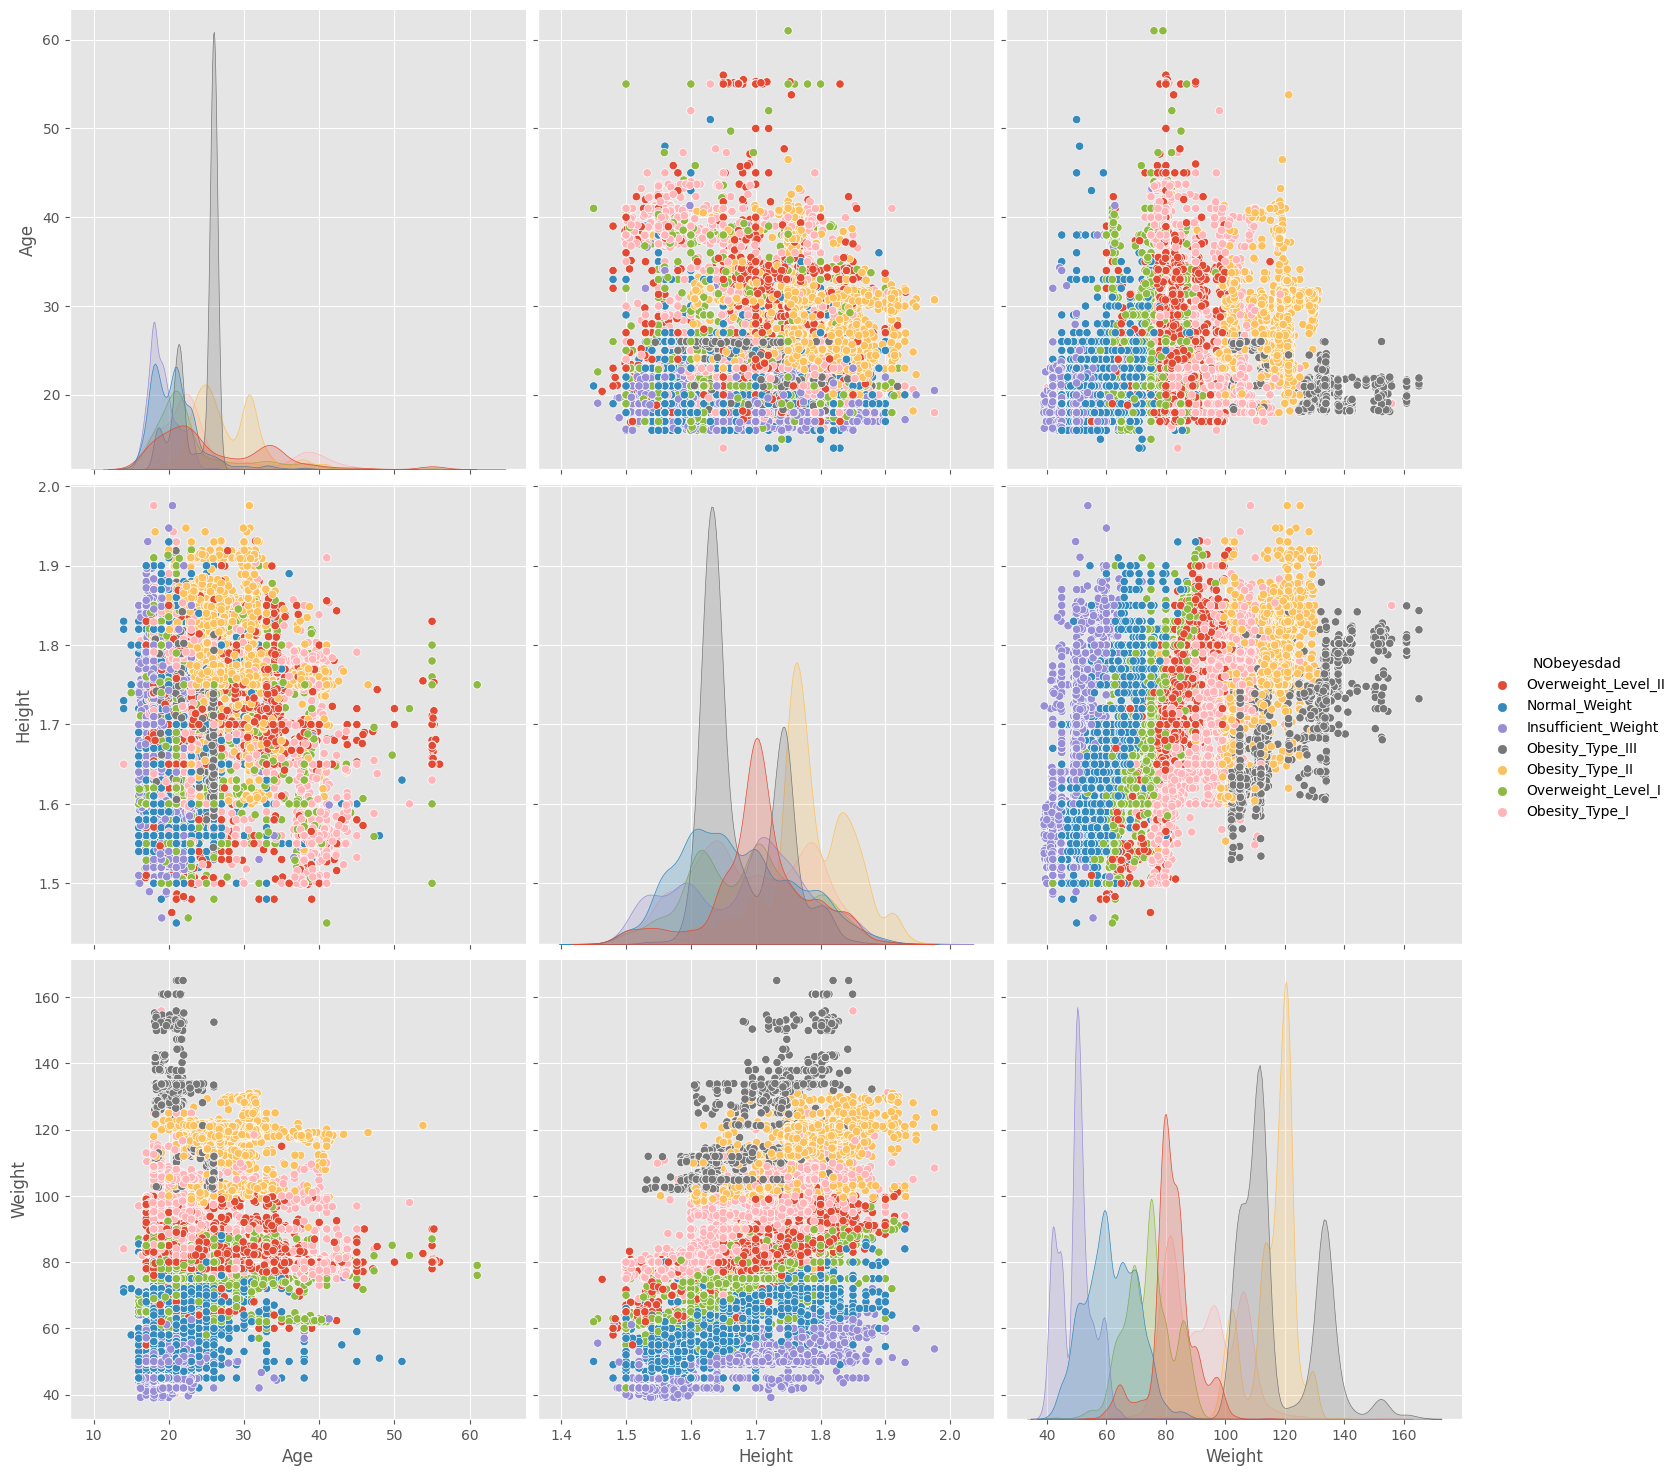

In [8]:
sns.pairplot(data = train[['Age', 'Height', 'Weight', 'NObeyesdad']], hue = 'NObeyesdad', height = 5);

From the above, it seems that there seven separable groups in the `Height` and `Weight` scatter-plot.

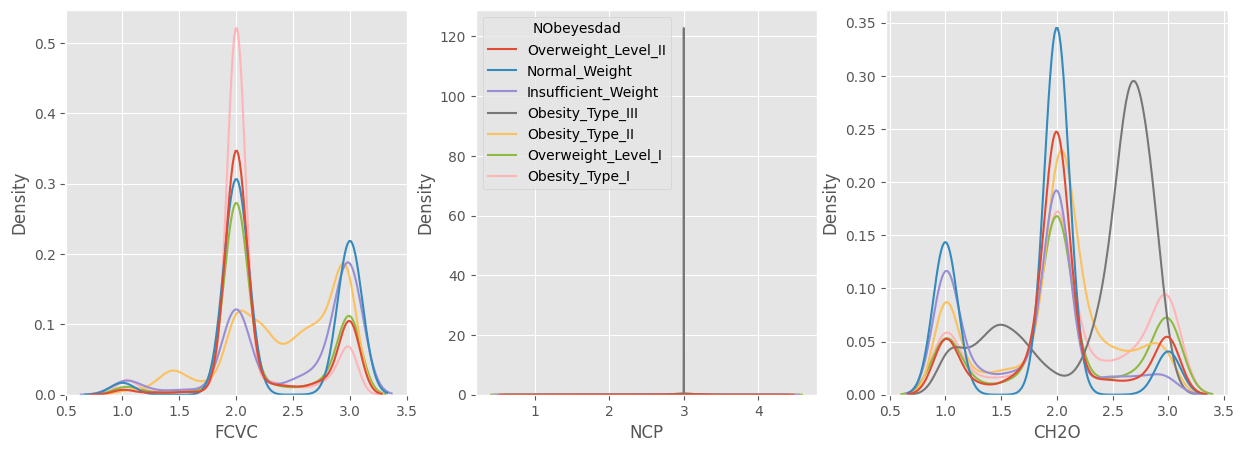

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

sns.kdeplot(ax = axes[0], data = train, x = 'FCVC', hue = 'NObeyesdad', legend = False)
sns.kdeplot(ax = axes[1], data = train, x = 'NCP', hue = 'NObeyesdad')
sns.kdeplot(ax = axes[2], data = train, x = 'CH2O', hue = 'NObeyesdad', legend = False);

From the above chart, these are a couple of observations:

* The distrubtion of the seven labels of `NObeyesdad` are very simliar in the `FCVC` feature.
* The distrubtion of the six labels of `NObeyesdad` are very simliar in the `CH2O` feature.

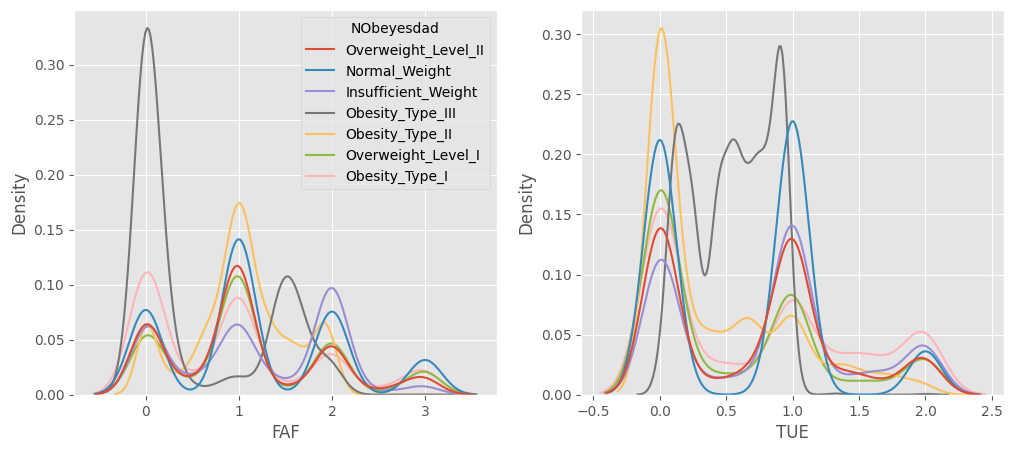

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.kdeplot(ax = axes[0], data = train, x = 'FAF', hue = 'NObeyesdad', legend = True)
sns.kdeplot(ax = axes[1], data = train, x = 'TUE', hue = 'NObeyesdad', legend = False);

From the above charts, we see that the distribution of six labels of `NObeyesdad` are very similar except by `Obesity_Type_III`. Next, we explore potential relationships between the categorical features and `NObeyesdad`.

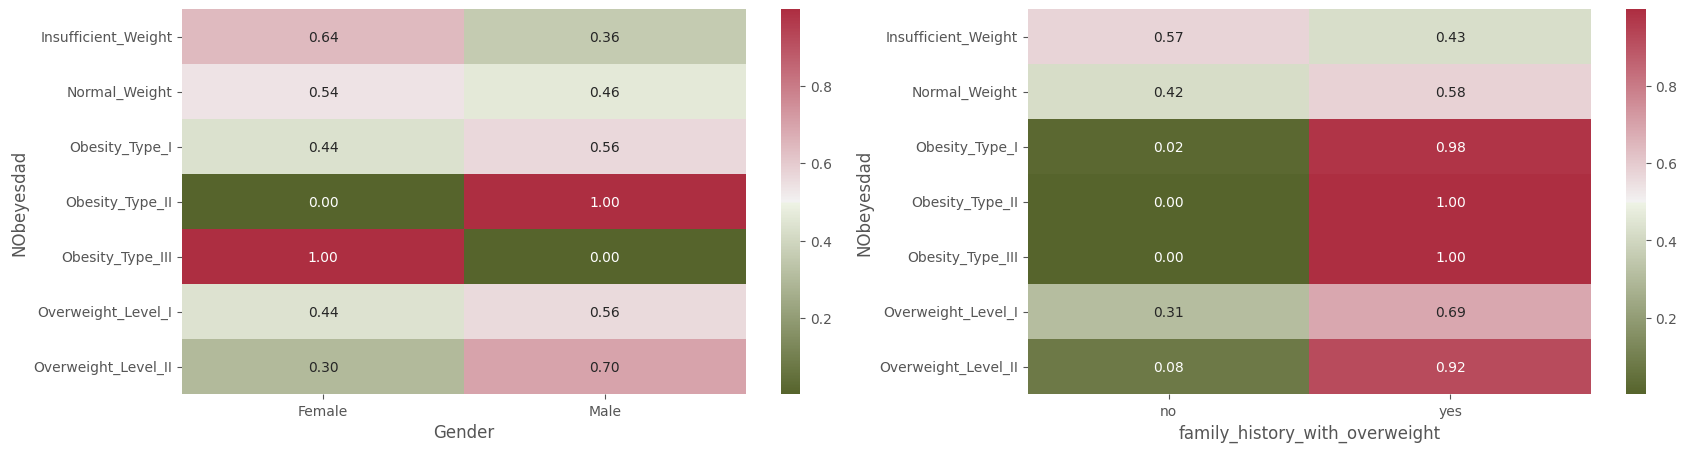

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['NObeyesdad'], train['Gender'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['NObeyesdad'], train['family_history_with_overweight'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

# Data Preprocessing

In [12]:
train['Gender'] = train['Gender'].map({'Female': 0, 'Male': 1})
train['family_history_with_overweight'] = train['family_history_with_overweight'].map({'no': 0, 'yes': 1})
train['FAVC'] = train['FAVC'].map({'no': 0, 'yes': 1})
train['SMOKE'] = train['SMOKE'].map({'no': 0, 'yes': 1})
train['SCC'] = train['SCC'].map({'no': 0, 'yes': 1})

train_CAEC = pd.get_dummies(train['CAEC'], drop_first = True, dtype = int)
train_CAEC.columns = ['Frequently', 'Sometimes_CAEC', 'no_CAEC']
train_CALC = pd.get_dummies(train['CALC'], drop_first = True, dtype = int)
train_CALC.columns = ['Sometimes_CALC', 'no_CALC']
train_MTRANS = pd.get_dummies(train['MTRANS'], drop_first = True, dtype = int)

train = train.drop(columns = ['CAEC', 'CALC', 'MTRANS'], axis = 1)
train = pd.concat([train, train_CAEC, train_CALC, train_MTRANS], axis = 1)

le = LabelEncoder()
le.fit(train['NObeyesdad'])
train['NObeyesdad'] = le.transform(train['NObeyesdad'])

test['Gender'] = test['Gender'].map({'Female': 0, 'Male': 1})
test['family_history_with_overweight'] = test['family_history_with_overweight'].map({'no': 0, 'yes': 1})
test['FAVC'] = test['FAVC'].map({'no': 0, 'yes': 1})
test['SMOKE'] = test['SMOKE'].map({'no': 0, 'yes': 1})
test['SCC'] = test['SCC'].map({'no': 0, 'yes': 1})

test['CALC'] = np.where(test['CALC'] == 'Always', 'Frequently', test['CALC'])

test_CAEC = pd.get_dummies(test['CAEC'], drop_first = True, dtype = int)
test_CAEC.columns = ['Frequently', 'Sometimes_CAEC', 'no_CAEC']
test_CALC = pd.get_dummies(test['CALC'], drop_first = True, dtype = int)
test_CALC.columns = ['Sometimes_CALC', 'no_CALC']
test_MTRANS = pd.get_dummies(test['MTRANS'], drop_first = True, dtype = int)

test = test.drop(columns = ['CAEC', 'CALC', 'MTRANS'], axis = 1)
test = pd.concat([test, test_CAEC, test_CALC, test_MTRANS], axis = 1)

# Baseline Modeling 1.0

In this section, we start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [13]:
X = train.drop(columns = ['id', 'NObeyesdad'], axis = 1)
Y = train['NObeyesdad']

test_cv = test.drop(columns = ['id'], axis = 1)

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `RandomForest` model.

In [14]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(**{'n_estimators': 360,
                                                  'criterion': 'gini',
                                                  'max_depth': 13,
                                                  'min_samples_split': 23,
                                                  'min_samples_leaf': 2,
                                                  'max_features': 8,
                                                  'max_samples': 0.7493816444416028,
                                                  'random_state': 10,
                                                  'n_jobs': -1}),
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy score of the Random Forest model is {RF_cv.mean()}")

The average 10-folds oof accuracy score of the Random Forest model is 0.901338835109223
CPU times: user 164 ms, sys: 120 ms, total: 284 ms
Wall time: 34.9 s


Next, we train the `ExtraTrees` model.

In [15]:
%%time
ET_cv = cross_val_score(ExtraTreesClassifier(**{'n_estimators': 243,
                                                'criterion': 'gini',
                                                'max_depth': 14,
                                                'min_samples_split': 3,
                                                'min_samples_leaf': 2,
                                                'max_features': 10,
                                                'bootstrap': True,
                                                'max_samples': 0.8837621802103176,
                                                'random_state': 10,
                                                'n_jobs': -1}),
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy score of the Extra Trees is {ET_cv.mean()}")

The average 10-folds oof accuracy score of the Extra Trees is 0.8856819416393898
CPU times: user 81.5 ms, sys: 29.2 ms, total: 111 ms
Wall time: 14.6 s


Next, we train the `GradientBoosting` model.

In [16]:
%%time
GB_cv = cross_val_score(GradientBoostingClassifier(**{'n_estimators': 97,
                                                      'max_depth': 6,
                                                      'min_samples_split': 34,
                                                      'min_samples_leaf': 2,
                                                      'max_features': 7,
                                                      'subsample': 0.8731272615743274,
                                                      'random_state': 1}),
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy of the Gradient Boosting model is {GB_cv.mean()}")

The average 10-folds oof accuracy of the Gradient Boosting model is 0.9086616756041506
CPU times: user 207 ms, sys: 127 ms, total: 333 ms
Wall time: 54.2 s


Next, we train the `HistGradientBoosting` model.

In [17]:
%%time
HG_cv = cross_val_score(HistGradientBoostingClassifier(**{'l2_regularization': 6.000008724178498,
                                                          'early_stopping': False,
                                                          'learning_rate': 0.029955245028555295,
                                                          'max_iter': 271,
                                                          'max_depth': 15,
                                                          'max_bins': 255,
                                                          'min_samples_leaf': 23,
                                                          'max_leaf_nodes': 26,
                                                          'random_state': 10}), 
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy score of the HistGradient model is {HG_cv.mean()}")

The average 10-folds oof accuracy score of the HistGradient model is 0.9078913573368619
CPU times: user 184 ms, sys: 79.6 ms, total: 264 ms
Wall time: 43.8 s


Next, we train the `XGBoost` model.

In [18]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'tree_method': 'hist',
                                          'max_depth': 9,
                                          'learning_rate': 0.06166995324240719,
                                          'n_estimators': 804,
                                          'gamma': 3.4603195735784125,
                                          'min_child_weight': 22,
                                          'colsample_bytree': 0.5187247998462878,
                                          'subsample': 0.6537310763403047}), 
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy of the XGBoost model is {XGB_cv.mean()}")

The average 10-folds oof accuracy of the XGBoost model is 0.9054339438679573
CPU times: user 248 ms, sys: 105 ms, total: 353 ms
Wall time: 1min 3s


Next, we train the `CatBoost` model.

In [19]:
%%time
Cat_cv = cross_val_score(CatBoostClassifier(**{'loss_function': 'MultiClass',
                                               'iterations': 582,
                                               'learning_rate': 0.1379303845722024,
                                               'depth': 5,
                                               'random_strength': 0.5369190099892146,
                                               'bagging_temperature': 0.06875878392046555,
                                               'border_count': 189,
                                               'l2_leaf_reg': 4,
                                               'verbose': False,
                                               'task_type': 'CPU'}), 
                        X, 
                        Y, 
                        scoring = 'accuracy',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof accuracy of the CatBoost model is {Cat_cv.mean()}")

The average 10-folds oof accuracy of the CatBoost model is 0.9081318569073986
CPU times: user 302 ms, sys: 116 ms, total: 418 ms
Wall time: 1min 21s


Next, we build a `VotingClassifier` model with the above models.

In [20]:
md1 = RandomForestClassifier(**{'n_estimators': 360,
                                'criterion': 'gini',
                                'max_depth': 13,
                                'min_samples_split': 23,
                                'min_samples_leaf': 2,
                                'max_features': 8,
                                'max_samples': 0.7493816444416028,
                                'random_state': 10,
                                'n_jobs': -1})

md2 = ExtraTreesClassifier(**{'n_estimators': 243,
                              'criterion': 'gini',
                              'max_depth': 14,
                              'min_samples_split': 3,
                              'min_samples_leaf': 2,
                              'max_features': 10,
                              'bootstrap': True,
                              'max_samples': 0.8837621802103176,
                              'random_state': 10,
                              'n_jobs': -1})

md3 = GradientBoostingClassifier(**{'n_estimators': 97,
                                    'max_depth': 6,
                                    'min_samples_split': 34,
                                    'min_samples_leaf': 2,
                                    'max_features': 7,
                                    'subsample': 0.8731272615743274,
                                    'random_state': 1})

md4 = HistGradientBoostingClassifier(**{'l2_regularization': 6.000008724178498,
                                                          'early_stopping': False,
                                                          'learning_rate': 0.029955245028555295,
                                                          'max_iter': 271,
                                                          'max_depth': 15,
                                                          'max_bins': 255,
                                                          'min_samples_leaf': 23,
                                                          'max_leaf_nodes': 26,
                                                          'random_state': 10})

md5 = XGBClassifier(**{'tree_method': 'hist',
                       'max_depth': 9,
                       'learning_rate': 0.06166995324240719,
                       'n_estimators': 804,
                       'gamma': 3.4603195735784125,
                       'min_child_weight': 22,
                       'colsample_bytree': 0.5187247998462878,
                       'subsample': 0.6537310763403047})

md6 = CatBoostClassifier(**{'loss_function': 'MultiClass',
                            'iterations': 582,
                            'learning_rate': 0.1379303845722024,
                            'depth': 5,
                            'random_strength': 0.5369190099892146,
                            'bagging_temperature': 0.06875878392046555,
                            'border_count': 189,
                            'l2_leaf_reg': 4,
                            'verbose': False,
                            'task_type': 'CPU'})

voting_md = VotingClassifier(estimators = [('RF', md1),
                                           ('ET', md2), 
                                           ('GB', md3), 
                                           ('HG', md4),
                                           ('XGB', md5),
                                           ('Cat', md6)],
                             voting = 'soft',
                             n_jobs = -1)

voting_md

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=13,
                                                     max_features=8,
                                                     max_samples=0.7493816444416028,
                                                     min_samples_leaf=2,
                                                     min_samples_split=23,
                                                     n_estimators=360,
                                                     n_jobs=-1,
                                                     random_state=10)),
                             ('ET',
                              ExtraTreesClassifier(bootstrap=True, max_depth=14,
                                                   max_features=10,
                                                   max_samples=0.8837621802103176,
                                                   min_samples_leaf=2,
                                                   min_samples_split=3,
                                                   n_estim...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=22, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=804, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('Cat',
                              <catboost.core.CatBoostClassifier object at 0x7e4ed4998790>)],
                 n_jobs=-1, voting='soft')

In [21]:
%%time
vot_cv = cross_val_score(voting_md,
                         X, 
                         Y, 
                         scoring = 'accuracy',
                         cv = skf, 
                         n_jobs = -1)

print(f"The average 10-folds oof accuracy score of the voting classifier is {vot_cv.mean()}")

The average 10-folds oof accuracy score of the voting classifier is 0.9084206885344848
CPU times: user 885 ms, sys: 404 ms, total: 1.29 s
Wall time: 4min 40s


In [22]:
%%time
vot_md = voting_md.fit(X, Y)
vot_pred = vot_md.predict(test_cv)

submission['NObeyesdad'] = le.inverse_transform(vot_pred)
submission.head()

CPU times: user 5.02 s, sys: 456 ms, total: 5.48 s
Wall time: 35.6 s


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [23]:
submission.to_csv('baseline_sub.csv', index = False)